# Predicting Herd Immunity in NYC

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
import datetime
from datetime import date

In [2]:
#Setting sheet parameters for matplotlib
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams["figure.figsize"] = [16,7]
plt.style.use('fivethirtyeight')

# Loading Dataframe, Data Wrangling and Feature Creations

In [4]:
# Loading dataframe
df=pd.read_csv("Cumulative trends.csv",thousands=',')

#Keeping only Running Sum of Total Doses Administered column to make things simple. Renamed coulumns, dropped NaNs
# Changed data types
df=df.reindex(columns=["Date","Running Sum of Total Doses Administered (daily)"])
df.rename(columns={"Running Sum of Total Doses Administered (daily)":"Total # of Vaccines Administered"},inplace=True)
df.dropna(inplace=True)
pd.to_numeric(df["Total # of Vaccines Administered"])
df["Total # of Vaccines Administered"]=df["Total # of Vaccines Administered"].astype(int)

#Feature creation of a column that finds the difference between the Nth and Nth-1 day of Total # of Vaccines 
#Administered. Inserted back into DataFrame.
df["Daily_Vaccines_Given"]=np.insert((np.diff(df["Total # of Vaccines Administered"])),0,len(df))

#Changing Date columns in pandas datetime type.
df["Date"]=pd.to_datetime(df["Date"])
df.drop_duplicates(subset=["Date"],inplace=True)

#Feature creation of an int Day column, as we cannot pass datetime data into the regression.
df["Day #"]=np.arange(1,len(df)+1)
df.head()

,Date,Total # of Vaccines Administered,Daily_Vaccines_Given,Day #
0,2020-12-14,77,153,1
3,2020-12-15,2087,2010,2
6,2020-12-16,6636,4549,3
9,2020-12-17,11093,4457,4
12,2020-12-18,16852,5759,5


# Plotting Actual Change in Vaccinations per Day

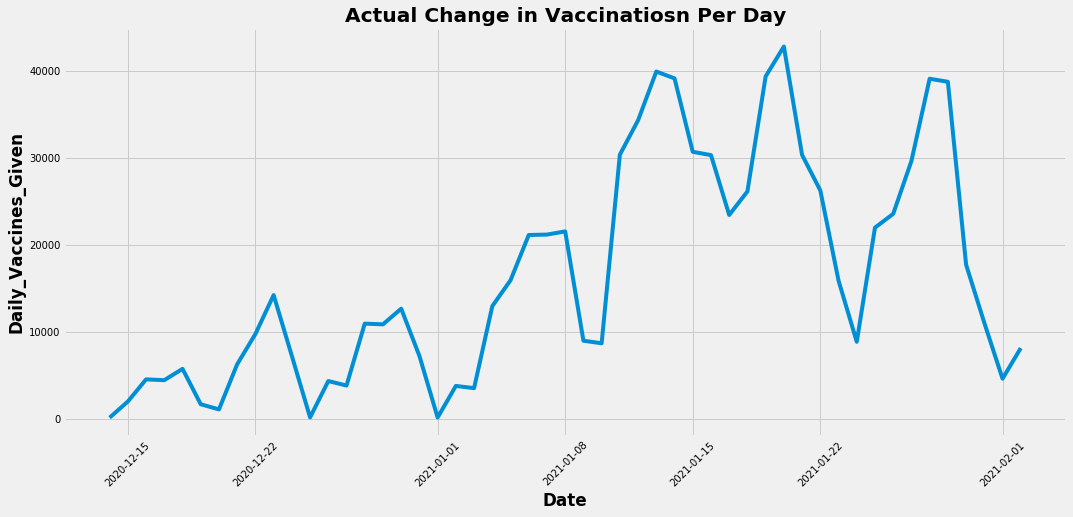

In [5]:
sns.lineplot(x="Date", y="Daily_Vaccines_Given", data=df)
plt.title("Actual Change in Vaccinatiosn Per Day",weight="bold")
plt.xticks(rotation=45)
plt.show()


# Training and Evaluating Model

In [6]:
#Reshaping data to make it one-dimnesional. 
X_data=(df["Day #"]).values.reshape(len(df),1)
y_data=np.array(df["Daily_Vaccines_Given"]).reshape(len(df),1)

#Witholding only %5 of data as test data to maximize data for model to train with
x_train,x_test, y_train, y_test= train_test_split(X_data, y_data, test_size=.05, random_state=0)

# Use GridSearchCV to select best values of alpha for the Ridge regressor 
lnr=Ridge()
params={"alpha":[1,10,100,1000,10000]}
clf=GridSearchCV(lnr,params,cv=5)
clf.fit(x_train,y_train)
clf.best_params_

{'alpha': 1000}

In [7]:
#Make a new Ridge regression classifier with the alpha parameter from above and then calculate the score.
lnr2=Ridge(alpha=1000)
lnr2.fit(x_train,y_train)
lnr2.score(x_test,y_test)

0.45156896866859264

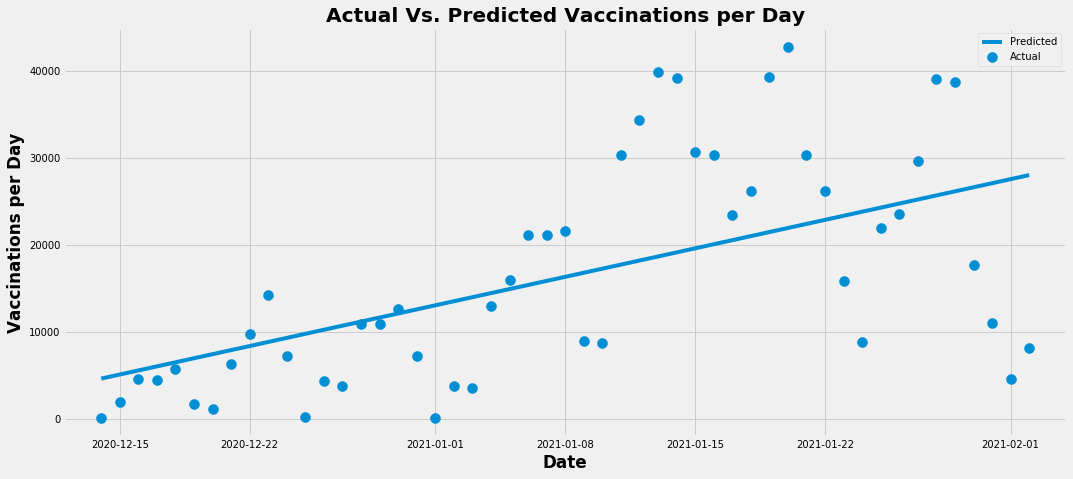

In [8]:
#Reshaping Day # column to be one-dimensional in order to be able to graph it
test=df["Day #"].values.reshape(len(df),1)

#Graphing actual vaccinations per day vs the regression's predicted vaccinations per day
plt.figure()
plt.scatter(df["Date"], df["Daily_Vaccines_Given"], label="Actual")
plt.plot(df["Date"], lnr2.predict(test), label="Predicted")
plt.xlim(df["Date"][0]-datetime.timedelta(2),df["Date"][-1:]+datetime.timedelta(2))
plt.title("Actual Vs. Predicted Vaccinations per Day",weight="bold")
plt.xlabel("Date")
plt.ylabel("Vaccinations per Day")
plt.legend()
plt.show()

# More Data Wrangling and Creation of New DataFrames

In [9]:
#Creating a new DataFrame that predicts the # of vaccines given of the days following the last day of actual data
Totalvaccines=int(df["Daily_Vaccines_Given"].agg(np.sum))
df2=pd.DataFrame(data=lnr2.predict((np.arange(len(df)+1,600).reshape(-1,1))), index=np.arange(len(df)+1,600),columns=["Daily_Vaccines_Given"])

#Assuming that once vaccination production is ramped up to an optimal level, it will be kept there until 
#herd immunity is reached. This transforms to transform subsequent data once respective optimal levels are reached.
optimal1=round((300000/7)) #300k vaccinations/week
optimal2=round((400000/7)) #400k vaccinations/week
optimal3=round((500000/7)) #500k vaccinations/week
df2[300000]=df2["Daily_Vaccines_Given"].apply(lambda x : optimal1 if x>=optimal1 else x)
df2[400000]=df2["Daily_Vaccines_Given"].apply(lambda x : optimal2 if x>=optimal2 else x)
df2[500000]=df2["Daily_Vaccines_Given"].apply(lambda x : optimal3 if x>=optimal3 else x)
df2

,Daily_Vaccines_Given,300000,400000,500000
52,28484.838841,28484.838841,28484.838841,28484.838841
53,28952.233170,28952.233170,28952.233170,28952.233170
54,29419.627499,29419.627499,29419.627499,29419.627499
55,29887.021828,29887.021828,29887.021828,29887.021828
56,30354.416157,30354.416157,30354.416157,30354.416157
...,...,...,...,...
595,282279.959495,42857.000000,57143.000000,71429.000000
596,282747.353824,42857.000000,57143.000000,71429.000000
597,283214.748153,42857.000000,57143.000000,71429.000000
598,283682.142482,42857.000000,57143.000000,71429.000000


In [10]:
#Adds a date column which contains the range of today's date to the length of DataFrame's days added to today.
today=date.today().strftime('%Y-%m-%d')
base = datetime.datetime.strptime(today, "%Y-%m-%d")
all_labels = [(base + datetime.timedelta(days=x)) for x in range(len(df2))]
df2["Date"]=all_labels
df2

,Daily_Vaccines_Given,300000,400000,500000,Date
52,28484.838841,28484.838841,28484.838841,28484.838841,2021-02-03
53,28952.233170,28952.233170,28952.233170,28952.233170,2021-02-04
54,29419.627499,29419.627499,29419.627499,29419.627499,2021-02-05
55,29887.021828,29887.021828,29887.021828,29887.021828,2021-02-06
56,30354.416157,30354.416157,30354.416157,30354.416157,2021-02-07
...,...,...,...,...,...
595,282279.959495,42857.000000,57143.000000,71429.000000,2022-07-31
596,282747.353824,42857.000000,57143.000000,71429.000000,2022-08-01
597,283214.748153,42857.000000,57143.000000,71429.000000,2022-08-02
598,283682.142482,42857.000000,57143.000000,71429.000000,2022-08-03


In [11]:
#Prepare both DataFrames to be concatenated
df[300000]=df["Daily_Vaccines_Given"].values
df[400000]=df["Daily_Vaccines_Given"].values
df[500000]=df["Daily_Vaccines_Given"].values
df.drop(columns=["Total # of Vaccines Administered","Day #"], inplace=True)
df2.set_index(["Date"], drop=True,inplace=True)
df.set_index(["Date"], drop=True, inplace=True)
#Concat DataFrames
df=pd.concat([df,df2])

#More data wrangling.
pd.set_option('display.float_format', '{:.2f}'.format)
df=df.round(0)
df.drop(columns=["Daily_Vaccines_Given"],inplace=True)

In [13]:
#At the time of the creation of this model, one-dose vaccines have not been approved yet. Therefore, we assume that 
#in order for a person to reach full immunity, they need two doses. Below, the current population in multiplied by
# 2 in order to meet the assumption. 
nycpop=(8419000*2)
df=df[(df.index> "2020-12-01") & (df.index<"2022-02-01")]

#A new DataFrame is made which transforms the daily vaccines given into a cumlative sum and then a percentage
# of the population that has been vaccinated.
cumsum=(df.cumsum())/nycpop
cumsum=cumsum.where(cumsum<1) *100
cumsum.head()

,300000,400000,500000
Date,,,
2020-12-14,0.00,0.00,0.00
2020-12-15,0.01,0.01,0.01
2020-12-16,0.04,0.04,0.04
2020-12-17,0.07,0.07,0.07
2020-12-18,0.10,0.10,0.10


# Plotting the Model for Forecasted Herd Immunity

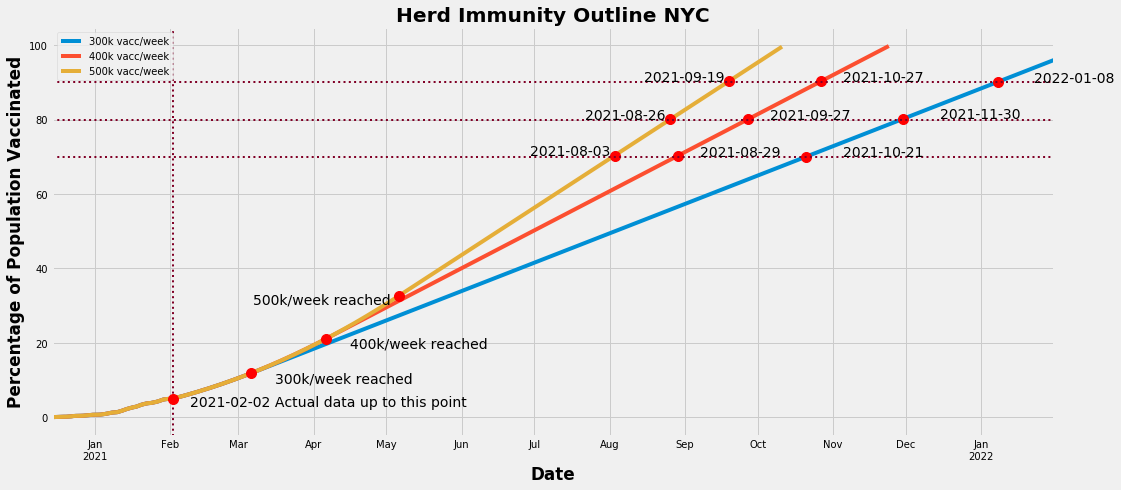

In [14]:
yesterday=pd.to_datetime(date.today()-datetime.timedelta(1))
yesterdaypct=cumsum[cumsum.index==pd.to_datetime(date.today()-datetime.timedelta(1))][300000][0]
yesterdaystr=yesterday.strftime("%Y-%m-%d")

fig,ax = plt.subplots()
cumsum.plot(ax=ax)
ax.legend(["300k vacc/week","400k vacc/week","500k vacc/week"])
plt.ylabel("Percentage of Population Vaccinated")
for x in [70,80,90]:
    plt.plot(cumsum[cumsum[300000]>=x].index[0],cumsum[cumsum[300000]>=x][300000][0],"ro")
    plt.text(cumsum[cumsum[300000]>=x].index[0]+ datetime.timedelta(15),cumsum[cumsum[300000]>=x][300000][0],cumsum[cumsum[300000]>=x].index[0].strftime("%Y-%m-%d"))
    plt.plot(cumsum[cumsum[400000]>=x].index[0],cumsum[cumsum[400000]>=x][400000][0],"ro")
    plt.text(cumsum[cumsum[400000]>=x].index[0]+ datetime.timedelta(9),cumsum[cumsum[400000]>=x][400000][0],cumsum[cumsum[400000]>=x].index[0].strftime("%Y-%m-%d"))
    plt.plot(cumsum[cumsum[500000]>=x].index[0],cumsum[cumsum[500000]>=x][500000][0],"ro")
    plt.text(cumsum[cumsum[500000]>=x].index[0]- datetime.timedelta(35),cumsum[cumsum[500000]>=x][500000][0],cumsum[cumsum[500000]>=x].index[0].strftime("%Y-%m-%d"))
    
ax.axhline(70, linestyle=":", linewidth=2, color="#800026")
ax.axhline(80, linestyle=":", linewidth=2, color="#800026")
ax.axhline(90, linestyle=":", linewidth=2, color="#800026")
ax.axvline(yesterday,linestyle=":", linewidth=2, color="#800026")
plt.plot(yesterday, yesterdaypct, "ro")
plt.text(yesterday + datetime.timedelta(7), yesterdaypct -2, f"{yesterdaystr} Actual data up to this point")
plt.title("Herd Immunity Outline NYC", weight="bold")
for n in [300000,400000,500000]:
    optimal1
    plt.plot(df[df[n]==round((n/7))].index[0],cumsum[cumsum.index==df[df[n]==round((n/7))].index[0]][n][0],"ro")
    if n==500000:
        plt.text(df[df[n]==round((n/7))].index[0] + datetime.timedelta(-60),cumsum[cumsum.index==df[df[n]==round((n/7))].index[0]][n][0]-2,"500k/week reached")
    else:
        plt.text(df[df[n]==round((n/7))].index[0] + datetime.timedelta(10),cumsum[cumsum.index==df[df[n]==round((n/7))].index[0]][n][0]-2.5,f"{str(n)[:3]}k/week reached")
        
plt.show()